## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [60]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
import joblib
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [61]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    
convert_mic('>64')

0

In [62]:
# Load meta data
meta_data = pd.read_excel('data/Cumulative_Peptide_data_PG1_v01.2.xlsx')
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
89,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
90,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
91,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


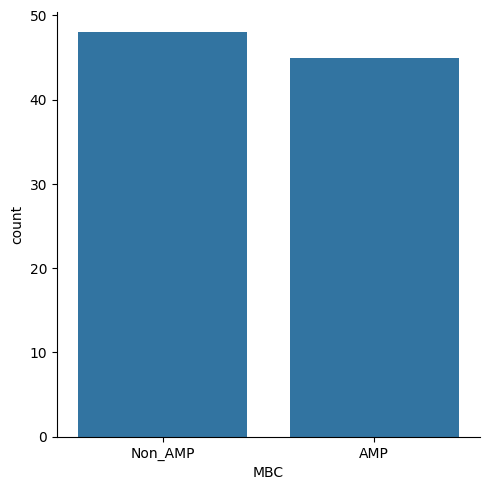

In [63]:
# Create the new target selectivity
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Load embedding

In [64]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,MBC,%Hemolysis,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
89,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
90,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
91,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [65]:
 # define target to evaluete the model
target = data["MBC"]

In [66]:
# define target
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


In [67]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (74, 5120), Test set shape: (19, 5120)


## Run models

In [68]:
pcas = [10, 15, 20, 25, 30, 35, 40, 70]

results_final = pd.DataFrame()
results_cv_final = pd.DataFrame()

for num_pca in pcas:
    # instantiate PCA
    pca = PCA(num_pca)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # store the results
    results = pd.DataFrame()
    results_cv = pd.DataFrame()

    # create a list of classifiers to test
    classifiers = [
        LogisticRegression(),
        GaussianNB(),
        SVC(),
    ]

    # create a dictionary of hyperparameters to search over for each classifier
    param_grids = [
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False], 'solver': ['liblinear', 'saga'],'max_iter': [100000]},
        {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,]},
        {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
    ]

    # create a list of names for the classifiers for printing results
    model_names = ["LogisticRegression", 'GaussianNB', "SVM", 'RandomForest']


    # loop over the classifiers and hyperparameter grids
    for name, clf, param_grid in zip(model_names, classifiers, param_grids):

        # create a GridSearchCV object with 5-fold cross-validation
        grid_search = GridSearchCV(clf, param_grid, cv=25, n_jobs=25)

        # fit the grid search object to the training data
        grid_search.fit(X_train_pca, y_train)

        # k-fold cross-validation on the training set
        accuracy_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='accuracy', n_jobs=25)
        recall_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='recall', n_jobs=25)
        precision_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='precision', n_jobs=25)
        f1_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='f1', n_jobs=25)


        # make predictions on the test data using the best model found by the grid search
        train_y_pred = grid_search.best_estimator_.predict(X_train_pca)
        test_y_pred = grid_search.best_estimator_.predict(X_test_pca)

        # evaluate the performance of the best model on the train data using accuracy score
        train_accuracy = metrics.accuracy_score(y_train, train_y_pred)
        train_recall = metrics.recall_score(y_train, train_y_pred)
        train_precision = metrics.precision_score(y_train, train_y_pred, zero_division=0)
        train_f1_score = metrics.f1_score(y_train, train_y_pred)

        # evaluate the performance of the best model on the test data using accuracy score
        test_accuracy = metrics.accuracy_score(y_test, test_y_pred)
        test_recall = metrics.recall_score(y_test, test_y_pred)
        test_precision = metrics.precision_score(y_test, test_y_pred, zero_division=0)
        test_f1_score = metrics.f1_score(y_test, test_y_pred)

        print(name)
        print(f'NUm PCA {num_pca}, Train Accuracy: {train_accuracy.round(2)}, Train Recall: {train_recall.round(2)}, Train Precision: {train_precision.round(2)}')
        print(f'NUm PCA {num_pca}, Test Accuracy: {test_accuracy.round(2)}, Test Recall: {test_recall.round(2)}, Test Precision: {test_precision.round(2)}')
        print()

        # Saving results
        res_dict = {}
        res_dict["embedding"] = 'esm2_15B'
        res_dict["embed_size"] = features.shape[1]
        res_dict["model"] = name
        res_dict["NUm_pca"] = num_pca

        res_dict["Train_Accuracy"] = train_accuracy.round(2)
        res_dict["Train_recall"] = train_recall.round(2)
        res_dict["Train_precision"] = train_precision.round(2)
        res_dict["Train_f1"] = train_f1_score.round(2)

        res_dict["Test_Accuracy"] = test_accuracy.round(2)
        res_dict["Test_recall"] = test_recall.round(2)
        res_dict["Test_precision"] = test_precision.round(2)
        res_dict["Test_f1"] = test_f1_score.round(2)
        res_dict['best_params'] = str(grid_search.best_params_)
        # updating data frame with results
        results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)
    

        # save results from cross-validation
        res_cv_dict = {
            "model": [name for i in range(len(accuracy_cv_scores))],
            "Num_pca": [num_pca for i in range(len(accuracy_cv_scores))],
            "Accuracy_CV_scores": accuracy_cv_scores,
            "Recall_CV_scores": recall_cv_scores,
            "Precision_CV_scores": precision_cv_scores,
            "F1_CV_scores": f1_cv_scores,
        }
        # updating data frame with results
        results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

    results_final = pd.concat([results_final, results]).reset_index(drop=True)
    results_cv_final = pd.concat([results_cv_final, results_cv]).reset_index(drop=True)

#results_final.to_excel('results/results_classification_activity_v02.xlsx')
#results_cv_final.to_excel('results/results_cv_classification_activity_v02.xlsx')

KeyboardInterrupt: 

## Results Visualization

In [ ]:
#results_cv = pd.read_excel('results/results_cv_classification_activity_v02.xlsx', index_col=0)
results_cv.groupby(['model', 'Num_pca']).mean()

,,Accuracy_CV_scores,Recall_CV_scores,Precision_CV_scores,F1_CV_scores
model,Num_pca,,,,
GaussianNB,40,0.620000,0.54,0.460000,0.464000
LogisticRegression,40,0.620000,0.74,0.520000,0.585333
SVM,40,0.613333,0.74,0.493333,0.569333


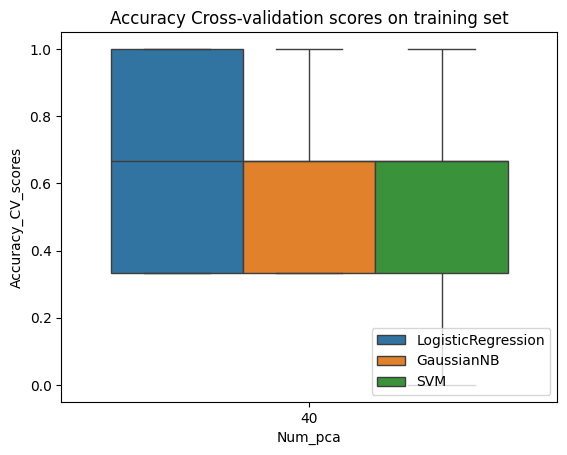

In [ ]:
sns.boxplot(data=results_cv, x='Num_pca', y='Accuracy_CV_scores', hue='model', showfliers=False)
plt.title('Accuracy Cross-validation scores on training set')
plt.legend(loc='lower right')
plt.show()

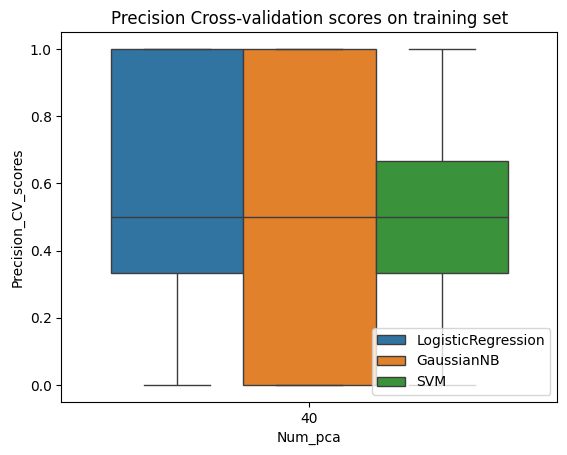

In [ ]:
sns.boxplot(data=results_cv, x='Num_pca', y='Precision_CV_scores', hue='model', showfliers=False)
plt.title('Precision Cross-validation scores on training set')
plt.legend(loc='lower right')
plt.show()

## Train x Test

In [ ]:
#results_final = pd.read_excel('results/results_classification_activity_v02.xlsx', index_col=0)
results_final

,embedding,embed_size,model,NUm_pca,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
0,esm2_15B,5120,LogisticRegression,10,0.80,0.82,0.75,0.78,0.68,0.67,0.80,0.73,"{'C': 10, 'fit_intercept': True, 'max_iter': 1..."
1,esm2_15B,5120,GaussianNB,10,0.78,0.82,0.73,0.77,0.68,0.58,0.88,0.70,{'var_smoothing': 1e-09}
2,esm2_15B,5120,SVM,10,0.95,1.00,0.89,0.94,0.63,0.58,0.78,0.67,"{'C': 10, 'class_weight': 'balanced', 'gamma':..."
3,esm2_15B,5120,LogisticRegression,15,0.78,0.82,0.73,0.77,0.58,0.58,0.70,0.64,"{'C': 1, 'fit_intercept': True, 'max_iter': 10..."
4,esm2_15B,5120,GaussianNB,15,0.81,0.82,0.77,0.79,0.84,0.83,0.91,0.87,{'var_smoothing': 1e-09}
5,esm2_15B,5120,SVM,15,0.97,1.00,0.94,0.97,0.68,0.67,0.80,0.73,"{'C': 10, 'class_weight': None, 'gamma': 0.1, ..."
6,esm2_15B,5120,LogisticRegression,20,0.81,0.82,0.77,0.79,0.68,0.67,0.80,0.73,"{'C': 1, 'fit_intercept': True, 'max_iter': 10..."
7,esm2_15B,5120,GaussianNB,20,0.81,0.82,0.77,0.79,0.68,0.75,0.75,0.75,{'var_smoothing': 0.0001}
8,esm2_15B,5120,SVM,20,0.92,0.94,0.89,0.91,0.63,0.67,0.73,0.70,"{'C': 10, 'class_weight': None, 'gamma': 'auto..."
9,esm2_15B,5120,LogisticRegression,25,0.76,0.85,0.68,0.76,0.68,0.75,0.75,0.75,"{'C': 0.1, 'fit_intercept': False, 'max_iter':..."


In [ ]:
# Reshape the dataframe to long format
melted_df = pd.melt(results_final, 
                    id_vars=['NUm_pca', 'model'], 
                    value_vars=['Test_Accuracy', 'Train_Accuracy'], 
                    var_name='Score Type', value_name='Accuracy')

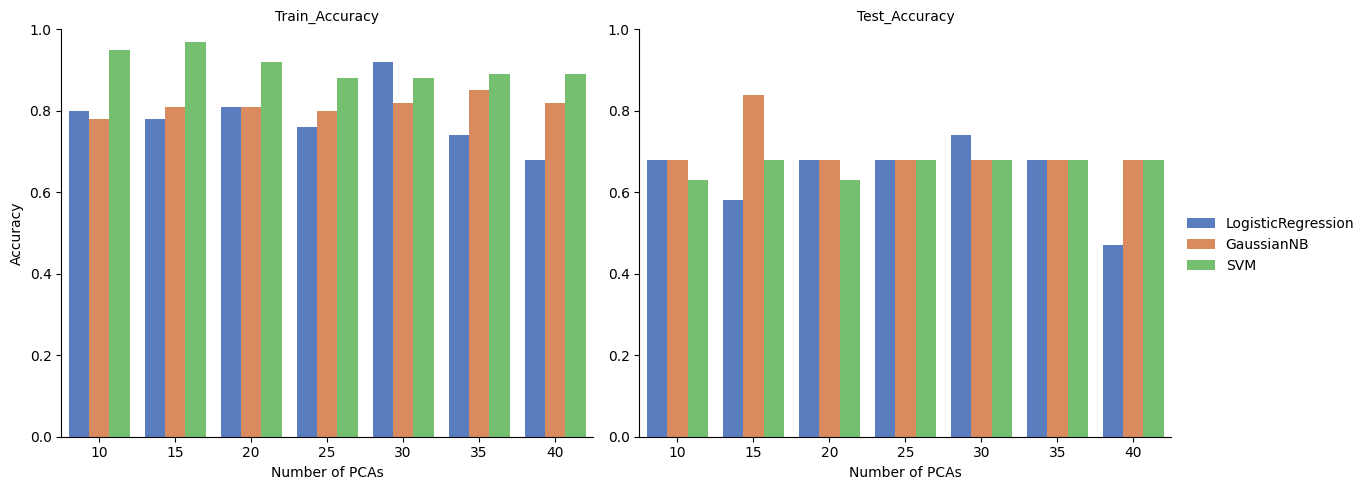

In [ ]:
# Example using FacetGrid for a categorical breakdown
g = sns.FacetGrid(melted_df, col="Score Type", sharey=False, height=5, aspect=1.2, ylim=(0,1), col_order=['Train_Accuracy', 'Test_Accuracy'])
g.map_dataframe(sns.barplot, x="NUm_pca", y="Accuracy", hue='model', palette='muted')
g.set_axis_labels("Number of PCAs", "Accuracy")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
plt.show()

To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.   
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.   
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

## Fine Tunning Model with best hyperparameter found with Gridsearch

In [ ]:
results_final.query('NUm_pca == 15')

,embedding,embed_size,model,NUm_pca,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
3,esm2_15B,5120,LogisticRegression,15,0.78,0.82,0.73,0.77,0.58,0.58,0.70,0.64,"{'C': 1, 'fit_intercept': True, 'max_iter': 10..."
4,esm2_15B,5120,GaussianNB,15,0.81,0.82,0.77,0.79,0.84,0.83,0.91,0.87,{'var_smoothing': 1e-09}
5,esm2_15B,5120,SVM,15,0.97,1.00,0.94,0.97,0.68,0.67,0.80,0.73,"{'C': 10, 'class_weight': None, 'gamma': 0.1, ..."


In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (74, 5120), Test set shape: (19, 5120)


In [ ]:
num_pca_components = 15

pca = PCA(num_pca_components)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Logistic Regression

In [ ]:
results_final.iloc[3, 12]

"{'C': 1, 'fit_intercept': True, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'liblinear'}"

In [ ]:
logR= LogisticRegression(penalty='l2',
                        C=1,
                        fit_intercept=True,
                        solver='liblinear',
                        max_iter=10000)
         

# fit the model
logR.fit(X_train_pca, y_train)

# print Accuracy score
print(f'Train R2 score: {logR.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {logR.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.78
Test R2 score: 0.58


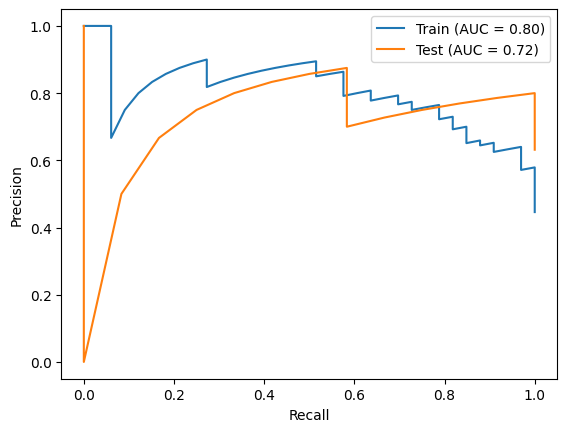

In [ ]:
# Predict probabilities on the training and testing sets
y_train_proba = logR.predict_proba(X_train_pca)[:, 1]
y_test_proba = logR.predict_proba(X_test_pca)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

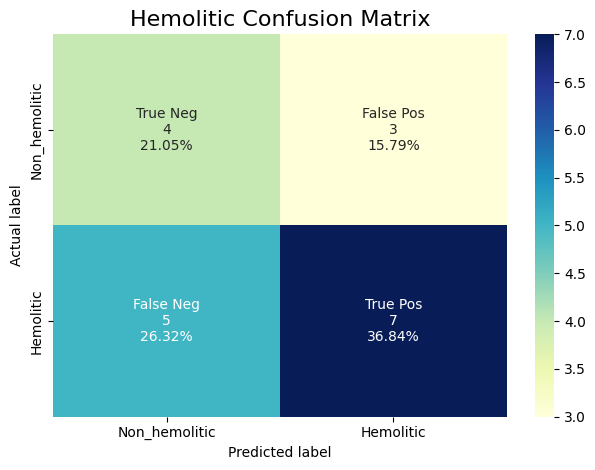

In [ ]:
#confusion_matrix, 
y_pred = logR.predict(X_test_pca)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_hemolitic', 'Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolitic Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Gaussian NB

In [ ]:
results_final.iloc[4, 12]

"{'var_smoothing': 1e-09}"

In [ ]:
gnb = GaussianNB(
    var_smoothing= 1e-09,
    )

gnb.fit(X_train_pca, y_train)

# print Accuracy score
print(f'Train R2 score: {gnb.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {gnb.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.81
Test R2 score: 0.84


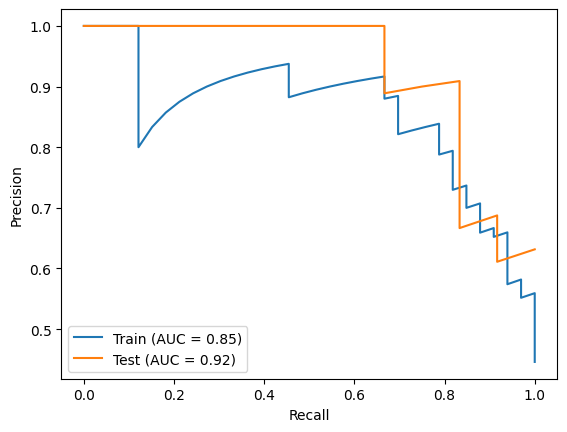

In [ ]:
# Predict probabilities on the training and testing sets
y_train_proba = gnb.predict_proba(X_train_pca)[:, 1]
y_test_proba = gnb.predict_proba(X_test_pca)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

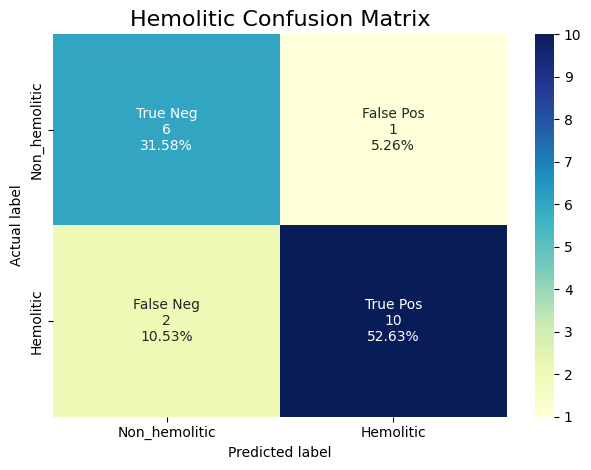

In [ ]:
#confusion_matrix, 
y_pred = gnb.predict(X_test_pca)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_hemolitic', 'Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolitic Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Save the model and PCA weights

In [ ]:
# Save the model
joblib.dump(gnb, 'models/model_v02_GNB15_esm2_15B_activity_classification.pkl')

# save pcs weights
joblib.dump(pca, 'models/weights_pca15_v02_esm2_15B_activity.pkl')

['models/weights_pca15_v02_esm2_15B_activity.pkl']

# Validation

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pickle
import joblib

In [2]:
# Loading the model
model = joblib.load('models/model_v02_GNB15_esm2_15B_activity_classification.pkl')

# Loading PCA weights
pca = joblib.load('models/weights_pca15_v02_esm2_15B_activity.pkl')

In [3]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('results/v01.2/predictions_validation_set_v01.2.csv')

####################### Load the embedding ######################
dir_path = 'data/embedding/esm2_15B_PG1_validation/'
embeddings = {}
for file in os.listdir(dir_path):
        file_path = str(dir_path) + file 
        label = file.split('.pt')[0]
        embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID2', right_index=True)


features = data.iloc[:,meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.109975,-0.134590,-0.111443,0.218644,-0.237748,0.131493,-0.119502,0.234007,-0.042554,0.338132,...,-0.136047,-0.087660,0.107472,-0.270478,0.122341,-0.089307,0.137297,0.075365,-0.198461,-0.035045
1,0.129701,-0.184889,-0.115536,0.161651,-0.224050,0.112427,-0.157890,0.269912,-0.049523,0.307800,...,-0.106790,-0.129787,0.076798,-0.208119,0.098149,-0.133004,0.089372,0.093026,-0.170869,-0.013929
2,0.099468,-0.114953,-0.117187,0.183187,-0.209792,0.091260,-0.130392,0.256235,-0.053187,0.229403,...,-0.195330,-0.116773,0.137988,-0.164647,0.119364,-0.178338,0.031593,0.029154,-0.215111,-0.017543
3,0.156776,-0.105166,-0.063266,0.204592,-0.202521,0.076685,-0.140390,0.251750,-0.082083,0.299491,...,-0.100395,-0.043842,0.144827,-0.125664,0.134358,-0.157067,0.040382,0.030294,-0.248444,0.020361
4,0.148965,-0.141826,-0.064849,0.198645,-0.237333,0.096351,-0.192772,0.201036,-0.055550,0.323271,...,-0.108473,-0.066790,0.079047,-0.211575,0.114173,-0.089037,0.146931,0.012782,-0.173229,0.016016


In [4]:
# calculates the probability of being active
prob = model.predict_proba(pca.transform(features))
pred = (prob[:, 1] * 100).round(2)

sum(pred > 90)

21

In [5]:
meta_data['activity_pred_v02'] = pred
meta_data

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,hemolysis_pred_v02,selectivity_pred_v02,activity_pred_v02
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,-3.285721,0.307504,92.34
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,-6.084995,0.272666,88.34
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,-6.281200,0.345484,95.37
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,-1.958412,0.618075,90.87
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,-2.783794,0.578861,94.94
5,PG1_3mut_1210489,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,<-0.25,16,0.735867,1.070920,-13.542688,-0.695068,-2.916473,0.343804,90.10
6,PG1_3mut_1536372,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,<-0.25,2,0.906433,0.258366,-3.345207,-0.416047,-3.252567,0.452450,94.73
7,PG1_3mut_1147726,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,<-0.25,16,0.043860,-0.153815,-12.337255,-0.839417,-1.449774,0.491094,98.64
8,PG1_3mut_1980555,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,<-0.25,32,0.116959,0.573184,-21.809423,-0.699560,-11.984425,0.122605,93.60
9,PG1_3mut_1658870,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,<-0.25,64,0.092593,0.772756,-9.999792,-0.342884,-4.005482,0.379449,93.70


In [6]:
meta_data.to_csv('results/v01.2/predictions_validation_set_v01.2.csv', index=False)